# Part 0 - Intro

In [24]:
## On Google Colaboratory only, install google drive stuff
'''
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
#'''

'\n!apt-get install -y -qq software-properties-common python-software-properties module-init-tools\n!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null\n!apt-get update -qq 2>&1 > /dev/null\n!apt-get -y install -qq google-drive-ocamlfuse fuse\nfrom google.colab import auth\nauth.authenticate_user()\nfrom oauth2client.client import GoogleCredentials\ncreds = GoogleCredentials.get_application_default()\nimport getpass\n!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL\nvcode = getpass.getpass()\n!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}\n#'

In [25]:
## On Google Colaboratory only, link google drive
'''
!mkdir -p drive
!google-drive-ocamlfuse drive
#'''

'\n!mkdir -p drive\n!google-drive-ocamlfuse drive\n#'

In [26]:
## On Google Colaboratory only, install necessary dependencies
#!pip install keras tensorflow-gpu && apt update && apt install -y python3-gdal

In [27]:
# Set number of GPUs
num_gpus = 4   #defaults to 1 if one-GPU or one-CPU. If 4 GPUs, set to 4.

# Set height (y-axis length) and width (x-axis length) to train model on
img_height, img_width = (512,512)  #Default to (256,256), use (None,None) if you do not want to resize imgs

In [28]:
# Import all the necessary libraries
import os
import datetime
import glob
import random
import re
import sys
import time
import zipfile

import tqdm

import matplotlib.pyplot as plt
import skimage.io                                     #Used for imshow function
import skimage.transform                              #Used for resize function
from PIL import Image, ImageDraw

import dask.array as da
import h5py
import numpy as np

import keras
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Conv2DTranspose
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Lambda, AlphaDropout
from keras.layers.advanced_activations import LeakyReLU
from keras.models import load_model, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.merge import add, concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
#from keras.utils import multi_gpu_model
from keras.utils.vis_utils import plot_model
from keras import backend as K

import tensorflow as tf
import sklearn
from sklearn.model_selection import train_test_split

import ogr
import gdal
from osgeo import gdal_array

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Skimage      :', skimage.__version__)
print('Scikit-learn :', sklearn.__version__)
print('Keras        :', keras.__version__)
print('Tensorflow   :', tf.__version__)
tf.test.gpu_device_name()

Python       : 3.7.12 (default, Sep 10 2021, 00:21:48) 
Numpy        : 1.19.5
Skimage      : 0.18.3
Scikit-learn : 1.0.1
Keras        : 2.7.0
Tensorflow   : 2.7.0


'/device:GPU:0'

In [29]:
# Set seed values
seed = 42
random.seed = seed
np.random.seed(seed=seed)
tf.random.set_seed(seed=seed)

In [30]:
# Have a look at our data folder
#topDir = os.getcwd()+"/data"  #default top directory
#topDir = "/content/drive/Colab Notebooks/data"  #default top directory on Google Colab
#os.chdir(topDir)
#print(os.listdir())
#os.getcwd()

# Part 1 - Data Input

In [31]:
# https://pcjericks.github.io/py-gdalogr-cookbook/raster_layers.html
# https://gis.stackexchange.com/questions/16837/how-can-i-turn-a-shapefile-into-a-mask-and-calculate-the-mean
def vectorPoly_to_rasterMask(vector, raster, suffix='_mask', output=None, show=False):
    """
    Function to turn a vector Polygon (ogr) into a raster binary mask (gdal) of 1 for present, 0 for absent
    
    Outputs a raster geotiff with extents according to the input raster.
    """
    if output==None:
        output = raster.split('.')[0]+suffix+"."+raster.split('.')[-1]
    
    
    ## Open raster data source
    assert(os.path.exists(raster))
    raster_ds = gdal.Open(raster)
    raster_prj = raster_ds.GetProjection()
    
    ulx, px, rx, uly, ry, py = raster_ds.GetGeoTransform()  #upper left X, pixel resolution X, rotation X, upper left Y, pixel resolution Y, rotation Y
    px, py = round(px,2), round(py,2)  #round pixel size to two decimal places
    width, height = raster_ds.RasterXSize, raster_ds.RasterYSize  #number of x columns and number of y rows
    #print(ulx, px, rx, uly, ry, py), (width, height)
    '''

      ul-------ur
    ^  |       |
    |  |  geo  |    y increases going up, x increases going right
    y  |       |
      ll-------lr
          x-->

    '''
    assert(rx==0 and ry==0)   #assuming zero rotation!!
    llx = ulx
    lly = uly + (height * py)
    urx = ulx + (width * px)
    ury = uly
    bbox = (llx, lly, urx, ury)  #minx, miny, maxx, maxy
    #print("min_xy:({0},{1}), max_xy:({2},{3})".format(*bbox))
    
    
    ## Open vector data source
    assert(os.path.exists(vector))
    vector_ds = ogr.Open(vector)
    vector_lyr = vector_ds.GetLayer()
    vector_prj = vector_lyr.GetSpatialRef()
    vector_ext = vector_lyr.GetExtent()   #x_min, x_max, y_min, y_max
    #print(vector_ext)
    
    
    ## Create the raster mask according to input raster dimensions
    #print((urx - llx) / px, (ury - lly) / abs(py))
    x_res = int(round((urx - llx) / px, 0))
    y_res = int(round((ury - lly) / abs(py), 0))  #turn negative pixel size y to absolute value
    #print(x_res, y_res)
    target_ds = gdal.GetDriverByName('GTiff').Create(output, x_res, y_res, 1, gdal.GDT_Byte)
    target_ds.SetGeoTransform((llx, px, rx, uly, ry, py))
    target_ds.SetProjection(raster_prj)
    band = target_ds.GetRasterBand(1)
    band.SetNoDataValue(np.nan)
    
    ## Rasterize
    err = gdal.RasterizeLayer(target_ds, [1], vector_lyr, None, None, [1], ['ALL_TOUCHED=TRUE'])
    target_ds.FlushCache()
    
    
    ## Create output arrays
    img_ary = np.dstack([raster_ds.GetRasterBand(i).ReadAsArray() for i in range(1,4)])
    msk_ary = target_ds.GetRasterBand(1).ReadAsArray()
   
    
    ## Visualize the raster with its output mask
    if show==True:
        #f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
        skimage.io.imshow(img_ary)
        plt.show()
        skimage.io.imshow(msk_ary)
        plt.show()
        #skimage.io.imsave(output, mask_ary)
    
    ## Final checks and turn mask into boolean array
    #print(img_ary.shape[:2], msk_ary.shape)
    assert(img_ary.shape[:2]==msk_ary.shape)   #check that shape of image and mask are the same
    msk_ary = skimage.transform.resize(msk_ary, output_shape=msk_ary.shape+(1,), mode='constant', preserve_range=True)  #need to add an extra dimension so mask.shape = (img_height, img_width, 1)
    msk_ary = msk_ary.astype(bool)  #convert to binary mask of either 0 or 1
    
    return img_ary, msk_ary

def ary_to_tiles(ary, shape=(256,256), exclude_empty=False):
    """
    Function to turn a big 2D numpy array (image) and tile it into a set number of shapes
    
    Outputs a stacked numpy array suitable for input into a Convolutional Neural Network
    """
    assert(isinstance(ary, np.ndarray))
    assert(isinstance(shape, tuple))
    
    ary_height, ary_width = shape
    ary_list = []
    
    total = 0
    excluded = 0
    for x_step in range(0, ary.shape[1], ary_width):
        for y_step in range(0, ary.shape[0], ary_height):
            x0, x1 = x_step, x_step+ary_width
            y0, y1 = y_step, y_step+ary_height
            
            crop_ary = ary[y0:y1, x0:x1]
            try:
                total += 1
                assert(crop_ary.shape == (ary_height, ary_width, ary.shape[2]))  #do not include images not matching the intended size
            except AssertionError:
                excluded += 1
                #print(y0,y1,x0,x1, 'excluded')
                continue
            ary_list.append(crop_ary)
    
    if excluded > 0:
        print("INFO: {0}/{1} tiles were excluded due to not fitting shape {2}".format(excluded, total, shape))
    return np.stack(ary_list), excluded

splitName = lambda filename: filename.split(os.sep)[-1].split('.')[0]   #function to strip filename of its directories and extension

In [32]:
'''
uzFullPath = topDir+"/raster/"  #full path to location of the will-be unzipped files
with tqdm.tqdm(total=len(glob.glob(topDir+"/raster/downloads/*.zip"))) as pbar:
    for i, zFile in enumerate(sorted(glob.glob(topDir+"/raster/downloads/*.zip"))):
        pbar.set_description('processing: {0}'.format(splitName(zFile)))
        pbar.update(1)
        with zipfile.ZipFile(file=zFile) as zf:
            for eachFile in zf.infolist():
                assert(len(eachFile.filename.split('/')) == 1)
                if not os.path.exists(os.path.join(uzFullPath, eachFile.filename)):
                    #print("Unzipping", eachFile.filename)
                    zf.extract(eachFile.filename, uzFullPath)
'''

'\nuzFullPath = topDir+"/raster/"  #full path to location of the will-be unzipped files\nwith tqdm.tqdm(total=len(glob.glob(topDir+"/raster/downloads/*.zip"))) as pbar:\n    for i, zFile in enumerate(sorted(glob.glob(topDir+"/raster/downloads/*.zip"))):\n        pbar.set_description(\'processing: {0}\'.format(splitName(zFile)))\n        pbar.update(1)\n        with zipfile.ZipFile(file=zFile) as zf:\n            for eachFile in zf.infolist():\n                assert(len(eachFile.filename.split(\'/\')) == 1)\n                if not os.path.exists(os.path.join(uzFullPath, eachFile.filename)):\n                    #print("Unzipping", eachFile.filename)\n                    zf.extract(eachFile.filename, uzFullPath)\n'

In [33]:
'''
if not os.path.exists('train/X_data.npz') or not os.path.exists('train/Y_data.npz'):
    with tqdm.tqdm(total=len(glob.glob(topDir+"/raster/downloads/*.zip"))) as pbar:
        for i, raster in enumerate(sorted(glob.glob(topDir+"/raster/*[!_mask].tif"))):
            tifName = splitName(raster)
            pbar.set_description('processing: {0}'.format(tifName))
            pbar.update(1)
            if not os.path.exists("train/X_{0}.hdf5".format(tifName)):
                img_ary_tmp, msk_ary_tmp = vectorPoly_to_rasterMask(vector='vector/nz-building-outlines-pilot.shp', raster=raster)
                # Generate stacked numpy tile blocks of size (img_height, img_width) from one geotiff
                X_data_tmp, _ = ary_to_tiles(img_ary_tmp, shape=(img_height, img_width))
                Y_data_tmp, _ = ary_to_tiles(msk_ary_tmp, shape=(img_height, img_width))
                # Convert stacked numpy array to dask array
                X_da_tmp = da.from_array(X_data_tmp, chunks=(32,img_height,img_width,1))
                Y_da_tmp = da.from_array(Y_data_tmp, chunks=(32,img_height,img_width,1))
                # Save dask array to HDF5 file format with maximum compression
                X_da_tmp.to_hdf5(filename="train/X_{0}.hdf5".format(tifName), datapath=tifName, compression="gzip", compression_opts=9)
                Y_da_tmp.to_hdf5(filename="train/Y_{0}.hdf5".format(tifName), datapath=tifName, compression="gzip", compression_opts=9)
            
    xdsets = [h5py.File(fn)['/'+splitName(fn)[2:]] for fn in sorted(glob.glob("train/X_*.hdf5"))]
    ydsets = [h5py.File(fn)['/'+splitName(fn)[2:]] for fn in sorted(glob.glob("train/Y_*.hdf5"))]
    xarys = [da.from_array(dset, chunks=(32,img_height,img_width,1)) for dset in xdsets]
    yarys = [da.from_array(dset, chunks=(32,img_height,img_width,1)) for dset in ydsets]
    xdata = da.concatenate(xarys, axis=0)  # Concatenate arrays along first axis
    ydata = da.concatenate(yarys, axis=0)  # Concatenate arrays along first axis
    # Clean up empty masks
    zero_mask = (ydata == 0).all(axis=(1,2,3))
    np.savez('train/Y_data.npz', Y_data=ydata[~zero_mask].compute())  #apply zero_mask to Y_train (masks) and save to uncompressed numpy format
    np.savez('train/X_data.npz', X_data=xdata[~zero_mask].compute())  #apply zero_mask to X_train (images) and save to uncompressed numpy format
    
if os.path.exists('train/X_data.npz') and os.path.exists('train/Y_data.npz'):
    X_data = np.load('train/X_data.npz')['X_data']
    Y_data = np.load('train/Y_data.npz')['Y_data']
'''

'\nif not os.path.exists(\'train/X_data.npz\') or not os.path.exists(\'train/Y_data.npz\'):\n    with tqdm.tqdm(total=len(glob.glob(topDir+"/raster/downloads/*.zip"))) as pbar:\n        for i, raster in enumerate(sorted(glob.glob(topDir+"/raster/*[!_mask].tif"))):\n            tifName = splitName(raster)\n            pbar.set_description(\'processing: {0}\'.format(tifName))\n            pbar.update(1)\n            if not os.path.exists("train/X_{0}.hdf5".format(tifName)):\n                img_ary_tmp, msk_ary_tmp = vectorPoly_to_rasterMask(vector=\'vector/nz-building-outlines-pilot.shp\', raster=raster)\n                # Generate stacked numpy tile blocks of size (img_height, img_width) from one geotiff\n                X_data_tmp, _ = ary_to_tiles(img_ary_tmp, shape=(img_height, img_width))\n                Y_data_tmp, _ = ary_to_tiles(msk_ary_tmp, shape=(img_height, img_width))\n                # Convert stacked numpy array to dask array\n                X_da_tmp = da.from_array(X_d

In [34]:
#print(X_data.shape, X_data.dtype)
#print(Y_data.shape, Y_data.dtype)

## Visualize masks on the training data

In [35]:
'''id = 128
print(X_data[id].shape)
skimage.io.imshow(X_data[id])
plt.show()
skimage.io.imshow(Y_data[id][:,:,0])
plt.show()'''

'id = 128\nprint(X_data[id].shape)\nskimage.io.imshow(X_data[id])\nplt.show()\nskimage.io.imshow(Y_data[id][:,:,0])\nplt.show()'

# Part 2 - Build model

In [36]:
# Custom IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.50, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score) 
        return K.mean(K.stack(prec), axis=0)

In [37]:
# Design our model architecture here
def keras_model(img_width=256, img_height=256, tensorboard_images=False):
    '''
    Modified from https://keunwoochoi.wordpress.com/2017/10/11/u-net-on-keras-2-0/
    Architecture inspired by https://blog.deepsense.ai/deep-learning-for-satellite-imagery-via-image-segmentation/
    '''
    #n_ch_exps = [4, 5, 6, 7, 8]   #the n-th deep channel's exponent i.e. 2**n 16,32,64,128,256
    n_ch_exps = [6, 6, 6, 6, 6]
    k_size = (3, 3)                     #size of filter kernel
    k_init = 'lecun_normal'             #kernel initializer
    activation = 'selu'

    if K.image_data_format() == 'channels_first':
        ch_axis = 1
        input_shape = (3, img_width, img_height)
    elif K.image_data_format() == 'channels_last':
        ch_axis = 3
        input_shape = (img_width, img_height, 3)

    inp = Input(shape=input_shape)
    if tensorboard_images == True:
        tf.summary.image(name='input', tensor=inp)
    encodeds = []

    # encoder
    enc = inp
    print(n_ch_exps)
    for l_idx, n_ch in enumerate(n_ch_exps):
        with K.name_scope('Encode_block_'+str(l_idx)):
            enc = Conv2D(filters=2**n_ch, kernel_size=k_size, activation=activation, padding='same', kernel_initializer=k_init)(enc)
            enc = AlphaDropout(0.1*l_idx,)(enc)
            enc = Conv2D(filters=2**n_ch, kernel_size=k_size, dilation_rate=(2,2), activation=activation, padding='same', kernel_initializer=k_init)(enc)
            encodeds.append(enc)
            #print(l_idx, enc)
            if l_idx < len(n_ch_exps)-1:  #do not run max pooling on the last encoding/downsampling step
                enc = MaxPooling2D(pool_size=(2,2))(enc)  #strides = pool_size if strides is not set
                #enc = Conv2D(filters=2**n_ch, kernel_size=k_size, strides=(2,2), activation=activation, padding='same', kernel_initializer=k_init)(enc)
            if tensorboard_images == True:
                tf.summary.histogram("conv_encoder", enc)
            
    # decoder
    dec = enc
    print(n_ch_exps[::-1][1:])
    decoder_n_chs = n_ch_exps[::-1][1:]
    for l_idx, n_ch in enumerate(decoder_n_chs):
        with K.name_scope('Decode_block_'+str(l_idx)):
            l_idx_rev = len(n_ch_exps) - l_idx - 1  #
            dec = concatenate([dec, encodeds[l_idx_rev]], axis=ch_axis)
            dec = Conv2D(filters=2**n_ch, kernel_size=k_size, dilation_rate=(2,2), activation=activation, padding='same', kernel_initializer=k_init)(dec)
            dec = AlphaDropout(0.1*l_idx)(dec)
            dec = Conv2D(filters=2**n_ch, kernel_size=k_size, activation=activation, padding='same', kernel_initializer=k_init)(dec)
            dec = Conv2DTranspose(filters=2**n_ch, kernel_size=k_size, strides=(2,2), activation=activation, padding='same', kernel_initializer=k_init)(dec)

    outp = Conv2DTranspose(filters=1, kernel_size=k_size, activation='sigmoid', padding='same', kernel_initializer='glorot_normal')(dec)
    if tensorboard_images == True:
        tf.summary.image(name='output', tensor=outp)
    
    model = Model(inputs=[inp], outputs=[outp])
    
    return model

In [38]:
# Set some model compile parameters
#optimizer = keras.optimizers.Adam()
optimizer = tf.keras.optimizers.Adam()
loss      = 'binary_crossentropy'
metrics   = [mean_iou]

# Compile our model
model = keras_model(img_width=img_width, img_height=img_height)
model.summary()

# For more GPUs
#if num_gpus > 1:
#    model = multi_gpu_model(model, gpus=num_gpus)
    
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

[6, 6, 6, 6, 6]
[6, 6, 6, 6]
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_54 (Conv2D)             (None, 512, 512, 64  1792        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 alpha_dropout_27 (AlphaDropout  (None, 512, 512, 64  0          ['conv2d_54[0][0]']              
 )                              )                              

# Part 3 - Run model

In [39]:
# Runtime custom callbacks

# Live loss plot from https://github.com/deepsense-ai/intel-ai-webinar-neural-networks/blob/master/live_loss_plot.py
# Fixed code to enable non-flat loss plots on keras model.fit_generator()
'''
import matplotlib.pyplot as plt
from keras.callbacks import Callback
from IPython.display import clear_output
#from matplotlib.ticker import FormatStrFormatter

def translate_metric(x):
    translations = {'acc': "Accuracy", 'loss': "Log-loss (cost function)"}
    if x in translations:
        return translations[x]
    else:
        return x

class PlotLosses(Callback):
    def __init__(self, figsize=None):
        super(PlotLosses, self).__init__()
        self.figsize = figsize

    def on_train_begin(self, logs={}):

        self.base_metrics = [metric for metric in self.params['metrics'] if not metric.startswith('val_')]
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs.copy())

        clear_output(wait=True)
        plt.figure(figsize=self.figsize)
        
        for metric_id, metric in enumerate(self.base_metrics):
            plt.subplot(1, len(self.base_metrics), metric_id + 1)
            
            plt.plot(range(1, len(self.logs) + 1),
                     [log[metric] for log in self.logs],
                     label="training")
            if self.params['do_validation']:
                plt.plot(range(1, len(self.logs) + 1),
                         [log['val_' + metric] for log in self.logs],
                         label="validation")
            plt.title(translate_metric(metric))
            plt.xlabel('epoch')
            plt.legend(loc='center left')
        
        plt.tight_layout()
        plt.show();

plot_losses = PlotLosses(figsize=(16, 4))

# Tensorboard
tensorboard = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True, write_images=True)

# Model Checkpoints
if not os.path.exists(topDir+"/model"):
    os.makedirs(topDir+"/model")
filepath="model/weights-{epoch:02d}-{val_mean_iou:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_mean_iou', verbose=1, save_best_only=True, save_weights_only=True, mode='max')

# Bring all the callbacks together into a python list
callbackList = [plot_losses, tensorboard, checkpoint]
'''

'\nimport matplotlib.pyplot as plt\nfrom keras.callbacks import Callback\nfrom IPython.display import clear_output\n#from matplotlib.ticker import FormatStrFormatter\n\ndef translate_metric(x):\n    translations = {\'acc\': "Accuracy", \'loss\': "Log-loss (cost function)"}\n    if x in translations:\n        return translations[x]\n    else:\n        return x\n\nclass PlotLosses(Callback):\n    def __init__(self, figsize=None):\n        super(PlotLosses, self).__init__()\n        self.figsize = figsize\n\n    def on_train_begin(self, logs={}):\n\n        self.base_metrics = [metric for metric in self.params[\'metrics\'] if not metric.startswith(\'val_\')]\n        self.logs = []\n\n    def on_epoch_end(self, epoch, logs={}):\n        self.logs.append(logs.copy())\n\n        clear_output(wait=True)\n        plt.figure(figsize=self.figsize)\n        \n        for metric_id, metric in enumerate(self.base_metrics):\n            plt.subplot(1, len(self.base_metrics), metric_id + 1)\n       

In [40]:
'''
validation_split = 0.20
X_train, X_test, Y_train, Y_test = train_test_split(X_data,
                                                    Y_data,
                                                    train_size=1-validation_split,
                                                    test_size=validation_split,
                                                    random_state=seed)
print("X_train: {0} tiles, X_test: {1} tiles".format(len(X_train), len(X_test)))
'''

'\nvalidation_split = 0.20\nX_train, X_test, Y_train, Y_test = train_test_split(X_data,\n                                                    Y_data,\n                                                    train_size=1-validation_split,\n                                                    test_size=validation_split,\n                                                    random_state=seed)\nprint("X_train: {0} tiles, X_test: {1} tiles".format(len(X_train), len(X_test)))\n'

In [41]:
# Finally train the model!!
'''
batch_size = 32
epochs = 300

try:  #to load a checkpoint file if it exists
    checkfile = sorted(glob.glob(topDir+"/model/weights-*-*.hdf5"))[-1]
    model.load_weights(checkfile)
    initial_epoch = int(re.search(r"weights-(\d*)-", checkfile).group(1))
    print("Model weights loaded, resuming from epoch {0}".format(initial_epoch))
except IndexError:
    initial_epoch = 0
    try:
        model.load_weights(topDir+"/model/model-weights.hdf5")
        print("Model weights loaded, starting from epoch {0}".format(initial_epoch))
    except OSError:
        pass

model.fit(x=X_train, y=Y_train, verbose=1, validation_split=0.25, batch_size=batch_size, epochs=epochs, callbacks=callbackList, initial_epoch=initial_epoch)
#model.fit(x=X_train, y=Y_train, verbose=1, validation_data=(X_test, Y_test), batch_size=batch_size, epochs=epochs, callbacks=callbackList)
'''

'\nbatch_size = 32\nepochs = 300\n\ntry:  #to load a checkpoint file if it exists\n    checkfile = sorted(glob.glob(topDir+"/model/weights-*-*.hdf5"))[-1]\n    model.load_weights(checkfile)\n    initial_epoch = int(re.search(r"weights-(\\d*)-", checkfile).group(1))\n    print("Model weights loaded, resuming from epoch {0}".format(initial_epoch))\nexcept IndexError:\n    initial_epoch = 0\n    try:\n        model.load_weights(topDir+"/model/model-weights.hdf5")\n        print("Model weights loaded, starting from epoch {0}".format(initial_epoch))\n    except OSError:\n        pass\n\nmodel.fit(x=X_train, y=Y_train, verbose=1, validation_split=0.25, batch_size=batch_size, epochs=epochs, callbacks=callbackList, initial_epoch=initial_epoch)\n#model.fit(x=X_train, y=Y_train, verbose=1, validation_data=(X_test, Y_test), batch_size=batch_size, epochs=epochs, callbacks=callbackList)\n'

In [42]:
# Save the model weights to a hdf5 file
'''if num_gpus > 1:
    #Refer to https://stackoverflow.com/questions/41342098/keras-load-checkpoint-weights-hdf5-generated-by-multiple-gpus
    #model.summary()
    model_out = model.layers[-2]  #get second last layer in multi_gpu_model i.e. model.get_layer('model_1')
else:
    model_out = model
model_out.save_weights(filepath=topDir+"/model/model-weights.hdf5")'''

'if num_gpus > 1:\n    #Refer to https://stackoverflow.com/questions/41342098/keras-load-checkpoint-weights-hdf5-generated-by-multiple-gpus\n    #model.summary()\n    model_out = model.layers[-2]  #get second last layer in multi_gpu_model i.e. model.get_layer(\'model_1\')\nelse:\n    model_out = model\nmodel_out.save_weights(filepath=topDir+"/model/model-weights.hdf5")'

# Part 4 - Evaluate output

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
# Reload the model
model_loaded = keras_model(img_width=img_width, img_height=img_height)
model_loaded.load_weights("/content/drive/MyDrive/ChangeDetection/model-weights.hdf5")
model_loaded.compile(optimizer=optimizer, loss=loss, metrics=metrics)

[6, 6, 6, 6, 6]
[6, 6, 6, 6]


## Visualize predictions on the cross-validation test data

In [45]:
'''from skimage import io
filename = "/content/drive/MyDrive/ChangeDetection/After-Google_AOI_01.tif"
img = io.imread(filename, plugin='pil')
X_test = np.asarray(img)'''

'from skimage import io\nfilename = "/content/drive/MyDrive/ChangeDetection/After-Google_AOI_01.tif"\nimg = io.imread(filename, plugin=\'pil\')\nX_test = np.asarray(img)'

In [46]:
'''X_test = X_test[0:256,0:256,0:3]
X_test = np.reshape(X_test, (1,256,256,3))
X_test.shape'''

'X_test = X_test[0:256,0:256,0:3]\nX_test = np.reshape(X_test, (1,256,256,3))\nX_test.shape'

In [47]:
# Use model to predict test labels
#Y_hat_test = model_loaded.predict(X_test, verbose=1)
#print(Y_hat_test.shape, Y_hat_test.dtype)

In [48]:
'''
for i in range(10):
    try:
        id = random.randrange(0,len(Y_hat_test))
        print(id, X_test[id].shape)
        fig, axarr = plt.subplots(nrows=1, ncols=3, squeeze=False, figsize=(20,20))
        axarr[0, 0].imshow(X_test[id])
        axarr[0, 1].imshow(Y_hat_test[id][:,:,0])
        #axarr[0, 2].imshow(Y_test[id][:,:,0])
        plt.show()
    except TypeError:
        pass
        '''

'\nfor i in range(10):\n    try:\n        id = random.randrange(0,len(Y_hat_test))\n        print(id, X_test[id].shape)\n        fig, axarr = plt.subplots(nrows=1, ncols=3, squeeze=False, figsize=(20,20))\n        axarr[0, 0].imshow(X_test[id])\n        axarr[0, 1].imshow(Y_hat_test[id][:,:,0])\n        #axarr[0, 2].imshow(Y_test[id][:,:,0])\n        plt.show()\n    except TypeError:\n        pass\n        '

## Visualize predictions on the training data

In [49]:
#Y_hat_train = model_loaded.predict(X_train, verbose=1)
#print(Y_hat_train.shape, Y_hat_train.dtype)

In [50]:
'''for i in range(10):
    try:
        id = random.randrange(0,len(Y_hat_train))
        print(id, X_train[id].shape)
        fig, axarr = plt.subplots(nrows=1, ncols=3, squeeze=False, figsize=(20,20))
        axarr[0, 0].imshow(X_train[id], aspect='equal')
        axarr[0, 1].imshow(Y_hat_train[id][:,:,0], aspect='equal')
        axarr[0, 2].imshow(Y_train[id][:,:,0], aspect='equal')
        plt.show()
    except TypeError:
        pass
        '''

"for i in range(10):\n    try:\n        id = random.randrange(0,len(Y_hat_train))\n        print(id, X_train[id].shape)\n        fig, axarr = plt.subplots(nrows=1, ncols=3, squeeze=False, figsize=(20,20))\n        axarr[0, 0].imshow(X_train[id], aspect='equal')\n        axarr[0, 1].imshow(Y_hat_train[id][:,:,0], aspect='equal')\n        axarr[0, 2].imshow(Y_train[id][:,:,0], aspect='equal')\n        plt.show()\n    except TypeError:\n        pass\n        "

## Visualize predictions on the new data!!

In [51]:
def ary_to_tiles(ary, shape=(512,512), exclude_empty=False):
    """
    Function to turn a big 2D numpy array (image) and tile it into a set number of shapes
    
    Outputs a stacked numpy array suitable for input into a Convolutional Neural Network
    """
    assert(isinstance(ary, np.ndarray))
    assert(isinstance(shape, tuple))
    
    ary_height, ary_width = shape
    ary_list = []
    
    total = 0
    excluded = 0
    for x_step in range(0, ary.shape[1], ary_width):
        for y_step in range(0, ary.shape[0], ary_height):
            x0, x1 = x_step, x_step+ary_width
            y0, y1 = y_step, y_step+ary_height
            
            crop_ary = ary[y0:y1, x0:x1]
            try:
                total += 1
                assert(crop_ary.shape == (ary_height, ary_width, ary.shape[2]))  #do not include images not matching the intended size
            except AssertionError:
                excluded += 1
                #print(y0,y1,x0,x1, 'excluded')
                continue
            ary_list.append(crop_ary)
    
    if excluded > 0:
        print("INFO: {0}/{1} tiles were excluded due to not fitting shape {2}".format(excluded, total, shape))
    return np.stack(ary_list), excluded

In [52]:
# Load raster data into numpy array
#ds = gdal.Open('test/wellington-03m-rural-aerial-photos-2012-2013.tif') #get from https://data.linz.govt.nz/layer/51870-wellington-03m-rural-aerial-photos-2012-2013/   
filename = "/content/drive/MyDrive/ChangeDetection/Before_Bing_AOI_05.tif"
ds = gdal.Open(filename)
ary = np.dstack([ds.GetRasterBand(i).ReadAsArray() for i in range(1,4)])
W_test, _ = ary_to_tiles(ary, shape=(img_height, img_width))
W_test.shape

INFO: 9/24 tiles were excluded due to not fitting shape (512, 512)


(15, 512, 512, 3)

In [53]:
W_hat_test = model_loaded.predict(W_test, verbose=1)
print(W_hat_test.shape, W_hat_test.dtype)

1/1 [==============================] - 18s 18s/step
(15, 512, 512, 1) float32


In [54]:
len(W_test)

15

0 (512, 512, 3)
1 (512, 512, 3)
2 (512, 512, 3)
3 (512, 512, 3)
4 (512, 512, 3)
5 (512, 512, 3)
6 (512, 512, 3)
7 (512, 512, 3)
8 (512, 512, 3)
9 (512, 512, 3)
10 (512, 512, 3)
11 (512, 512, 3)
12 (512, 512, 3)
13 (512, 512, 3)
14 (512, 512, 3)


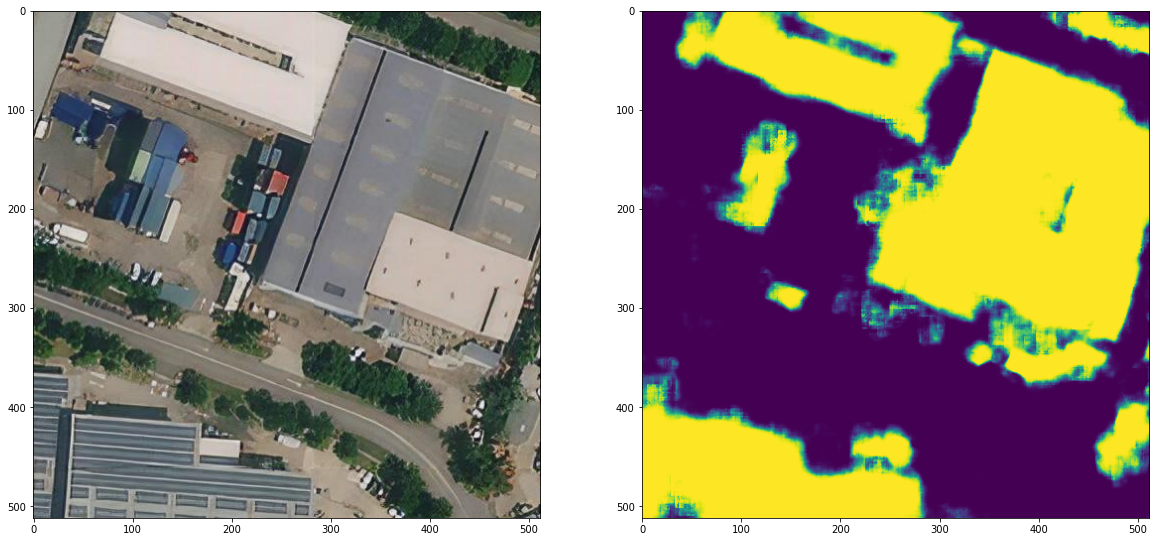

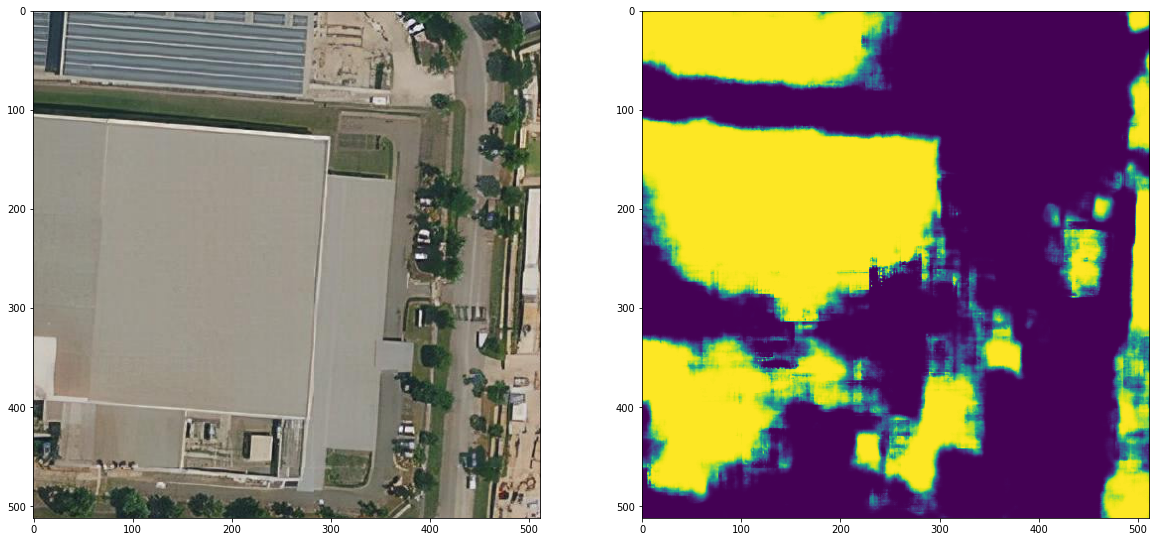

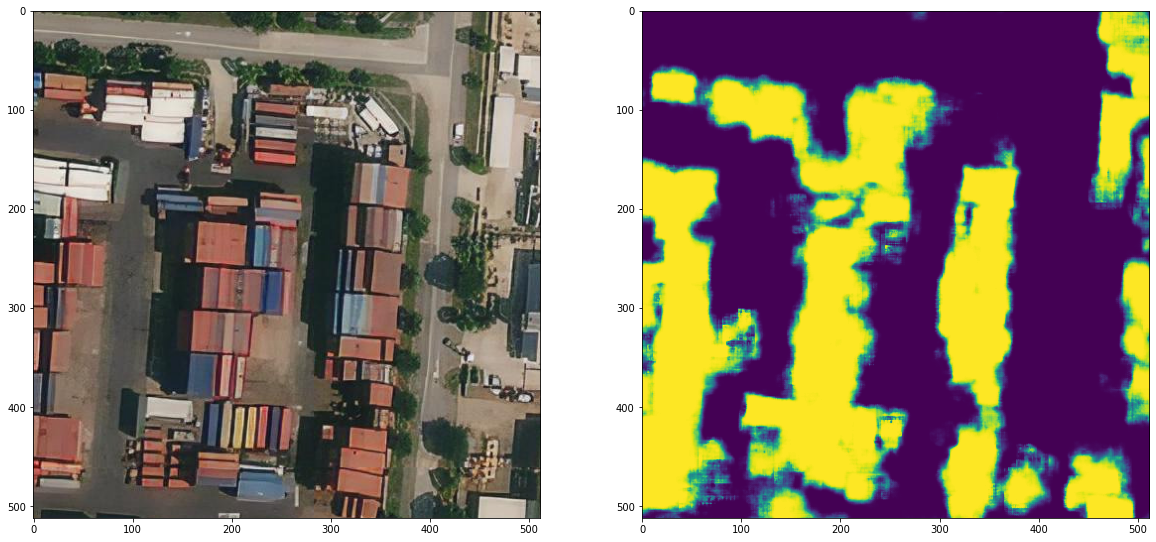

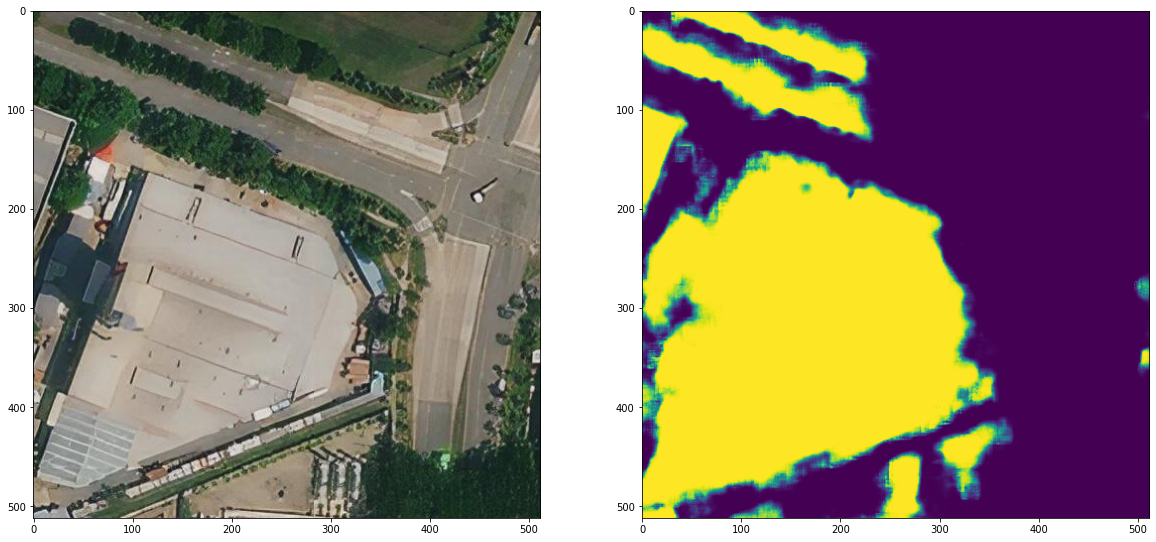

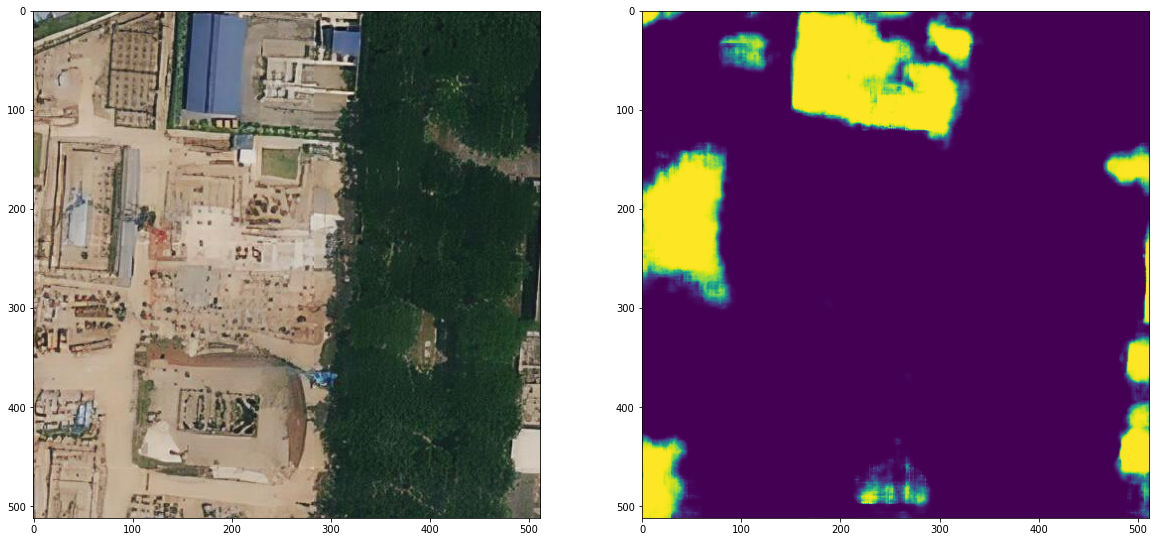

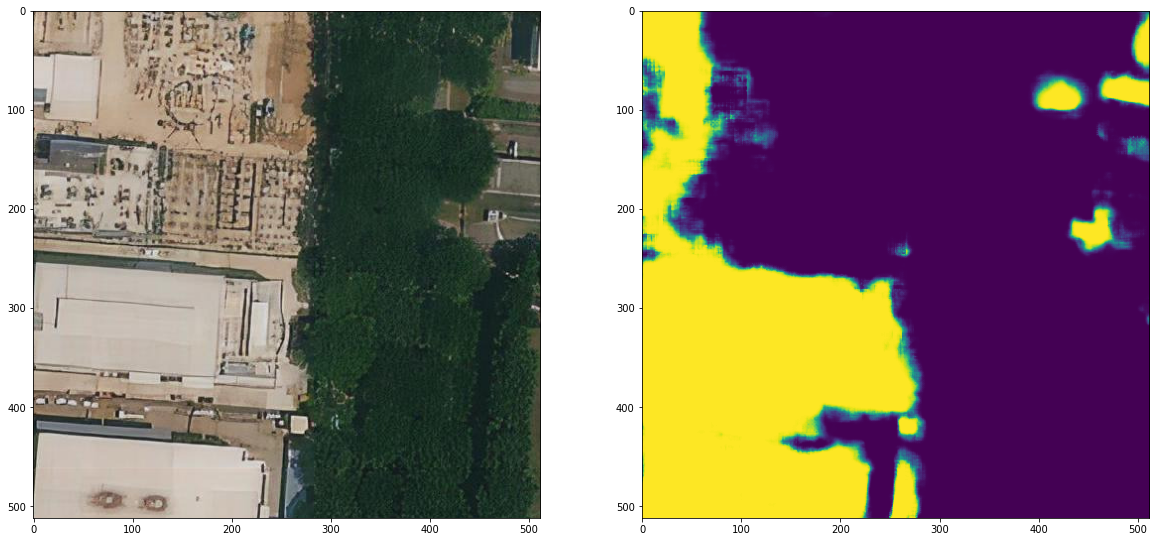

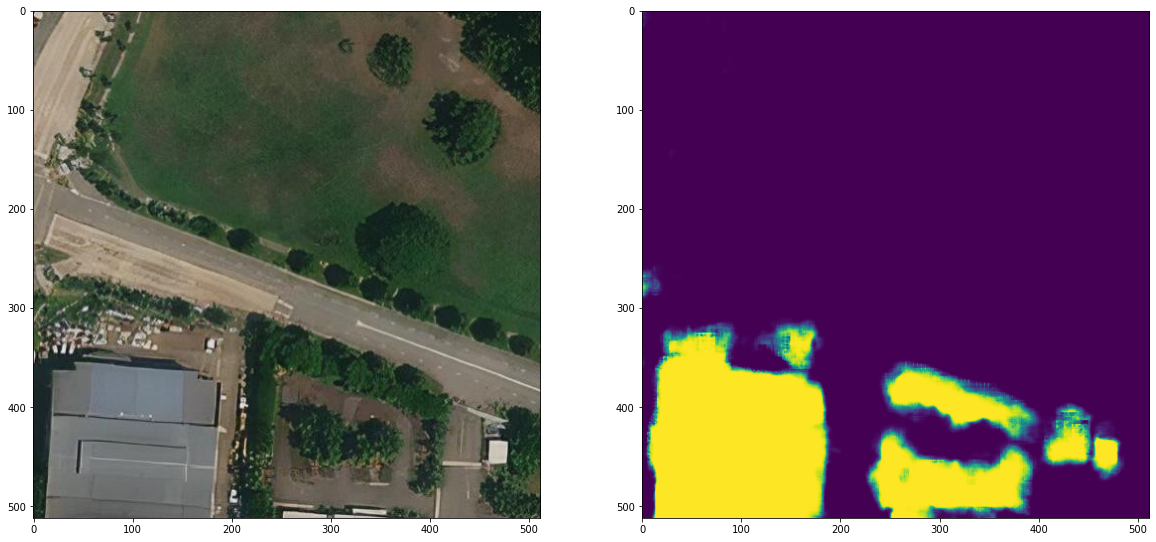

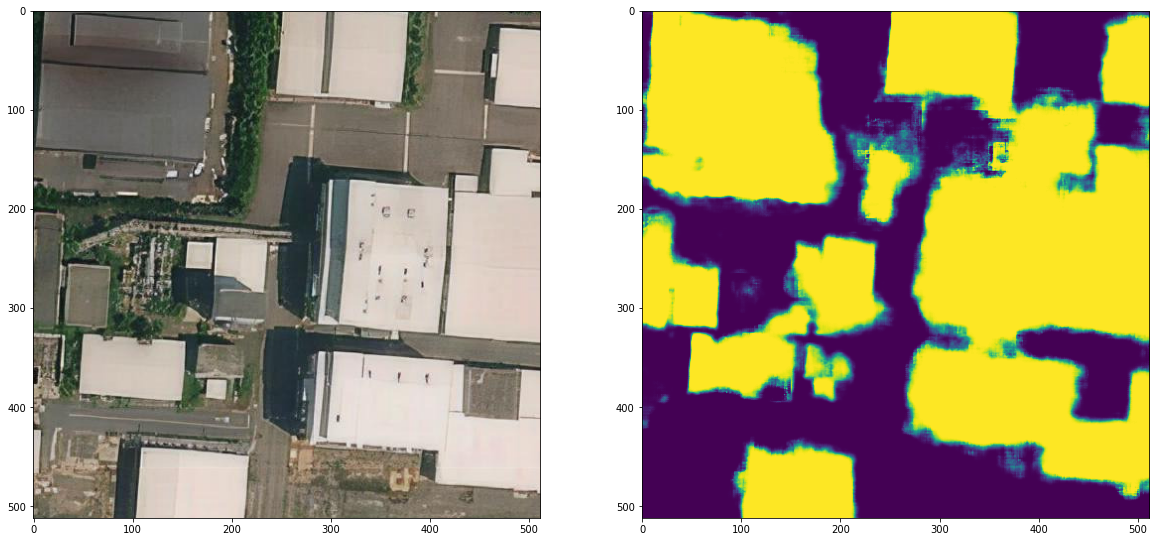

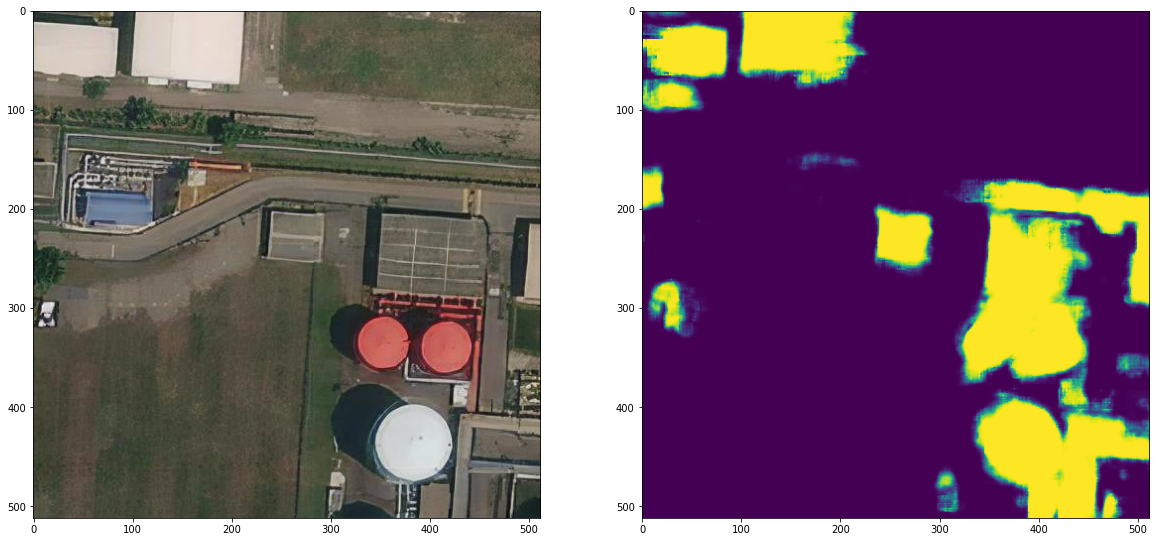

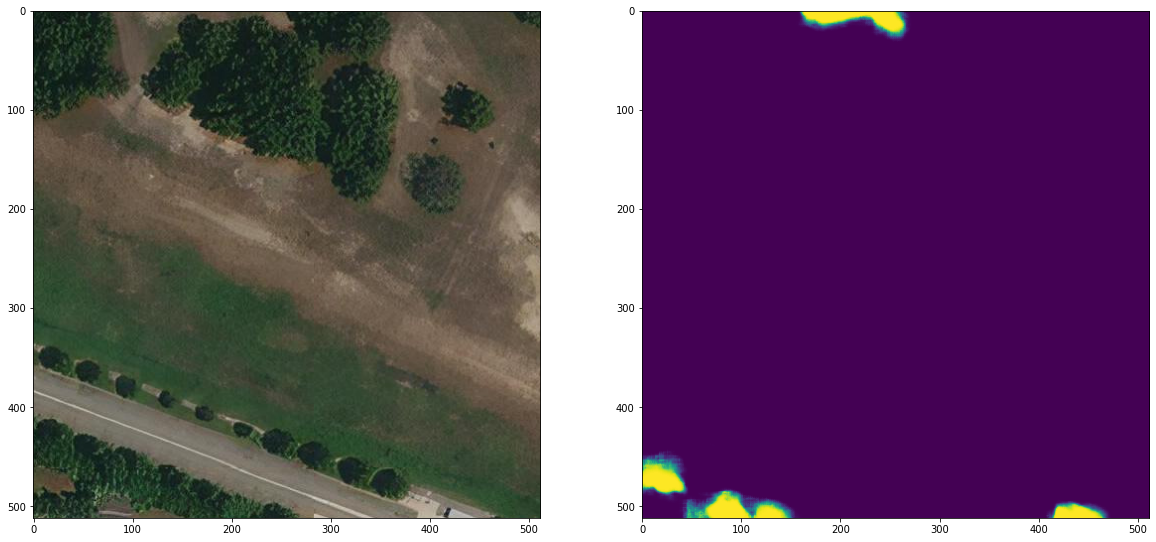

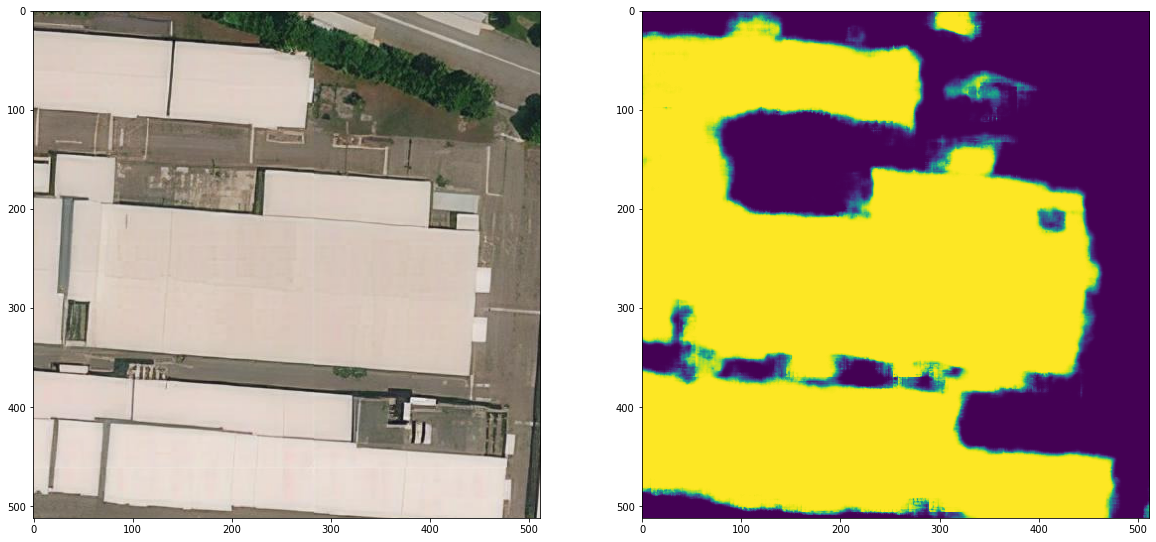

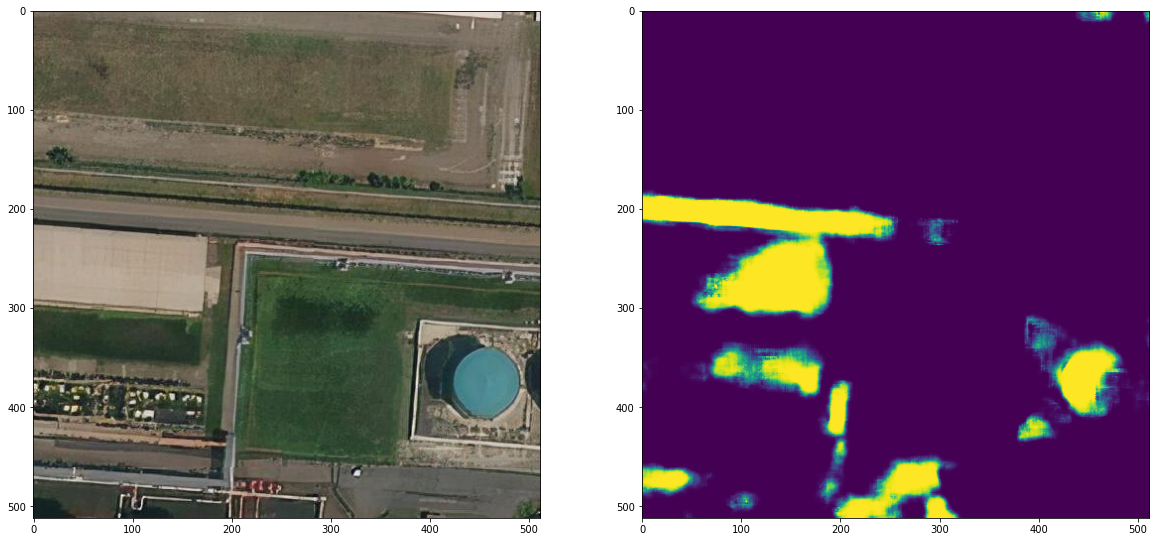

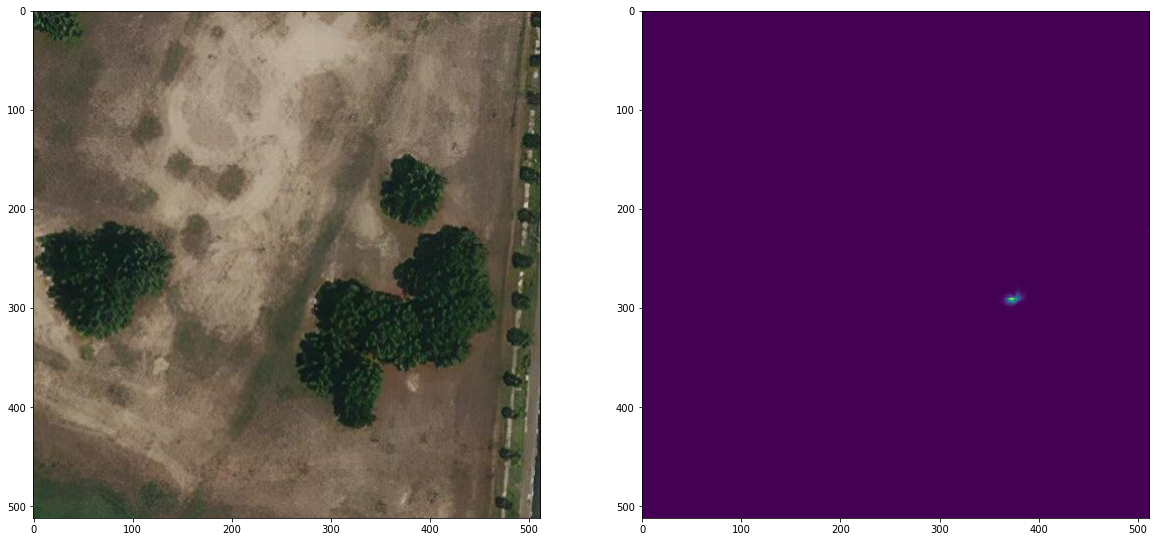

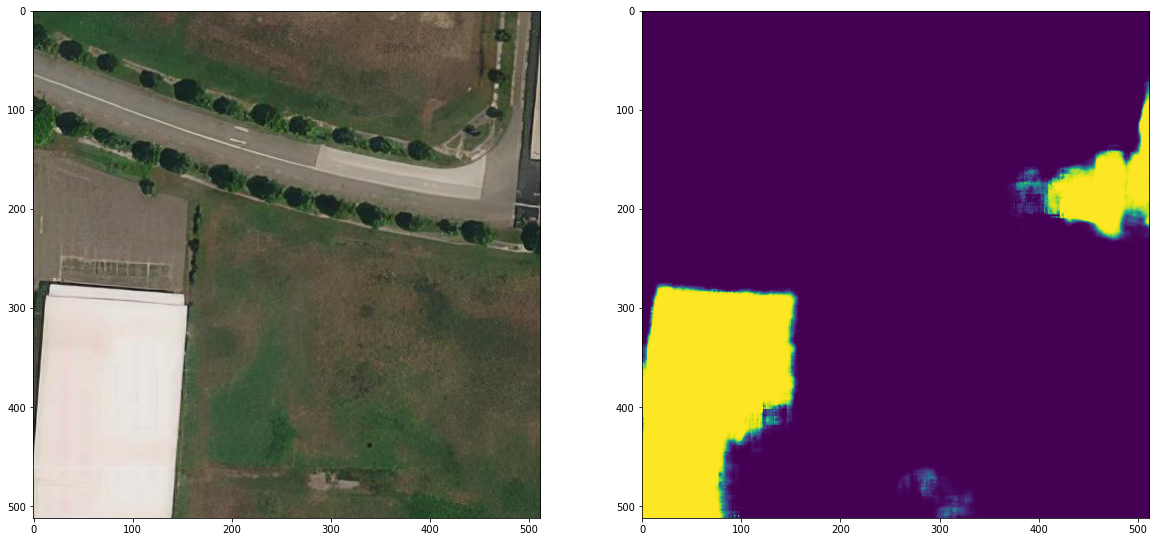

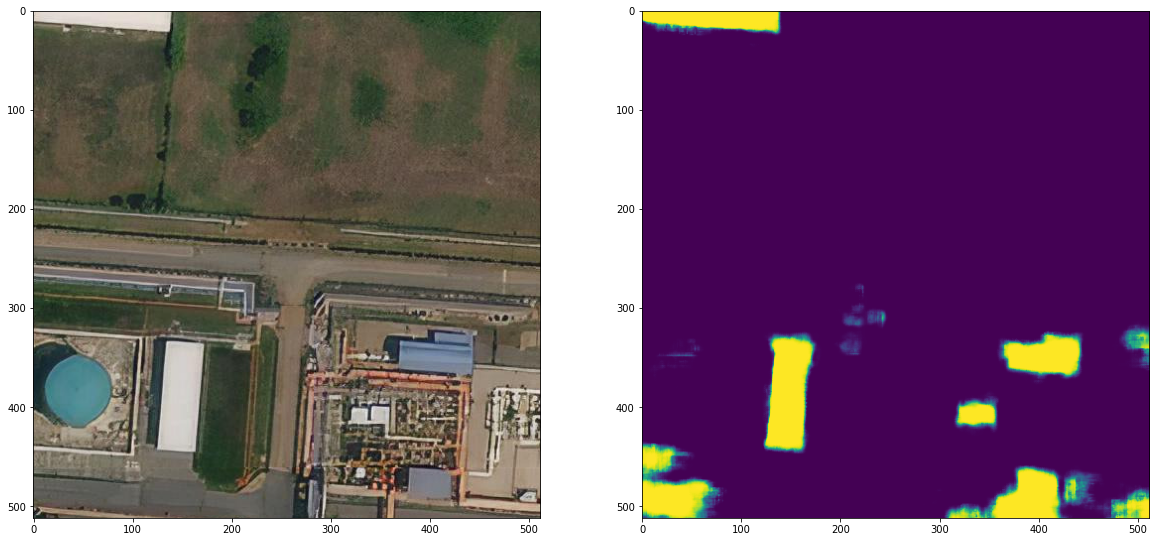

In [55]:
try:
    for id in range(0,len(W_test)): 
      print(id, W_test[id].shape)
      fig, axarr = plt.subplots(nrows=1, ncols=2, squeeze=False, figsize=(20,20))
      axarr[0, 0].imshow(W_test[id])
      axarr[0, 1].imshow(W_hat_test[id][:,:,0])
      #plt.show()
      saveFile = '/content/drive/MyDrive/ChangeDetection/output5/foo'+str(id)+'.png'
      plt.savefig(saveFile)
except TypeError:
  pass

In [56]:
'''
for i in range(10):
    try:
        id = random.randrange(0,len(W_test))
        print(id, W_test[id].shape)
        fig, axarr = plt.subplots(nrows=1, ncols=2, squeeze=False, figsize=(40,40))
        axarr[0, 0].imshow(W_test[id])
        axarr[0, 1].imshow(W_hat_test[id][:,:,0])
        #axarr[0, 2].imshow(W_test[id])
        plt.show()
    except TypeError:
        pass
        '''

'\nfor i in range(10):\n    try:\n        id = random.randrange(0,len(W_test))\n        print(id, W_test[id].shape)\n        fig, axarr = plt.subplots(nrows=1, ncols=2, squeeze=False, figsize=(40,40))\n        axarr[0, 0].imshow(W_test[id])\n        axarr[0, 1].imshow(W_hat_test[id][:,:,0])\n        #axarr[0, 2].imshow(W_test[id])\n        plt.show()\n    except TypeError:\n        pass\n        '

## Live prediction!!!

In [57]:
# Predicting live from your screen! Uses opencv
# Go to https://data.linz.govt.nz, Browse data -> Aerial Photos and select one to play with
# !python ../predict.py 512

# Part 5 - Save results
Here, we will use the trained keras ConvNet model to create a raster output of the predicted mask.

Inputs:
    .tif file (RGB image)
Outputs:
    .tif file (Binary mask)
    
The output will have floating point pixel values going from 0 to 1 where 0 is 'not a mask' and 1 is 'mask'

**Note**: Please make sure you run all the cells in 'Part 0 - Intro' and 'Part 2 - Build model', and the first cell in 'Part 1 - Data input' to load the necessary libraries and functions.